In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from scipy.stats import beta, norm
from scipy.stats import t as t_distribution
from scipy.special import beta as beta_function
from scipy.special import gamma as gamma_function
np.random.seed(42)

### Task 1
The goal is to approximate the value of $\pi$ using the Monte Carlo method. This approach relies on random sampling to estimate the area of a unit circle inscribed in a square.

### Problem Description
We consider a unit circle centered at the origin with radius r = 1. The circle is inscribed in a square with side length 2, spanning from (0,2) to (0,2).

We generate random points (x, y) uniformly distributed within the square:
$$
x, y \sim U(0,2)
$$
A point (x, y) falls inside the circle if it satisfies the inequality:
$$
(x-1)^2 + (y-1)^2 \leq 1
$$
The ratio of points inside the circle to the total number of points approximates the ratio of the areas:
$$
\frac{\text{points in circle}}{\text{total points}} \approx \mathbf{E}[\mathbf{1}\{(x-1)^2 + (y-1)^2 \leq 1\}] = \frac{\pi}{4}
$$


### Monte Carlo Algorithm
1. Generate $N$ random points (x, y) in the square.
2. Count how many points, $N_{\text{in}}$, satisfy $x^2 + y^2 \leq 1$.
3. Estimate $\pi$ using:
   $$
   \pi \approx 4 \times \frac{N_{\text{in}}}{N}
   $$

As $N$ increases, the estimate of $\pi$ becomes more accurate due to the law of large numbers. We illustrate it with the convergence plots in different scales.

In [4]:
def approx_pi(n):
    # Given number of samples n returns an approximation of \pi
    x = np.random.uniform(low = 0, high = 2, size = n)
    y = np.random.uniform(low = 0, high = 2, size = n)

    def if_in_circle(x, y):
      return (x - 1) ** 2 + (y - 1) ** 2 <= 1

    sample = if_in_circle(x, y)
    return sample.mean() * 4

In [5]:
smoothing_itertions_num = 100
M = 23
error = np.zeros(M)
for _ in tqdm(range(smoothing_itertions_num)):

    ms = np.arange(0, M)
    ns = [2 ** i for i in ms]
    approxis = np.array([approx_pi(n) for n in ns ])
    error += np.abs(approxis - np.pi)
error /= smoothing_itertions_num

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


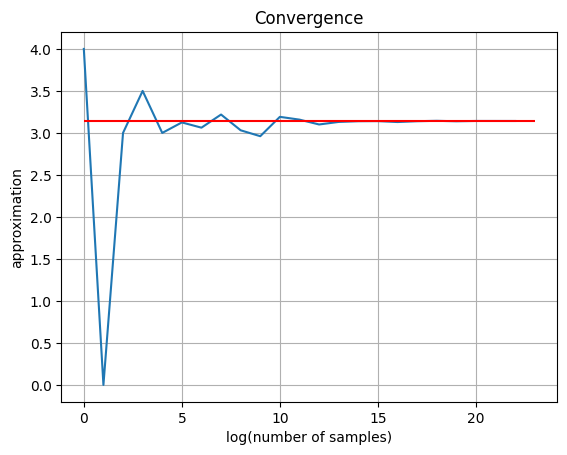

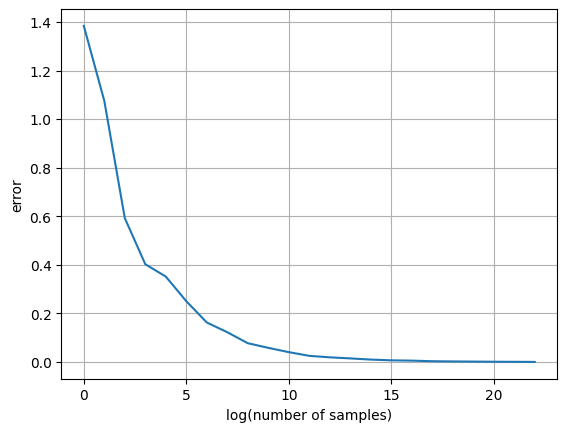

In [6]:
plt.plot(ms, approxis)
plt.title("Convergence")
plt.xlabel('log(number of samples)')
plt.ylabel('approximation')
plt.hlines(np.pi, 0, M, color='red', label='pi')
plt.grid(True)
plt.show()


plt.plot(ms, error)
plt.xlabel('log(number of samples)')
plt.ylabel('error')
plt.grid(True)
plt.show()

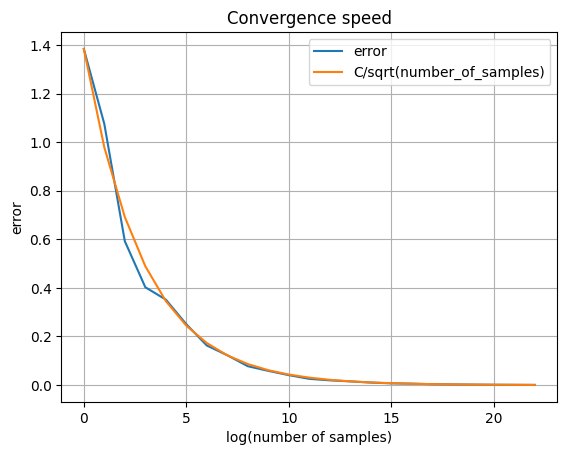

In [7]:
plt.plot(ms, error, label = 'error')
plt.title("Convergence speed")
plt.plot(ms, 1/np.sqrt(2**ms) * error[0], label = 'C/sqrt(number_of_samples)')
plt.xlabel('log(number of samples)')
plt.ylabel('error')
plt.grid(True)
plt.legend()
plt.show()

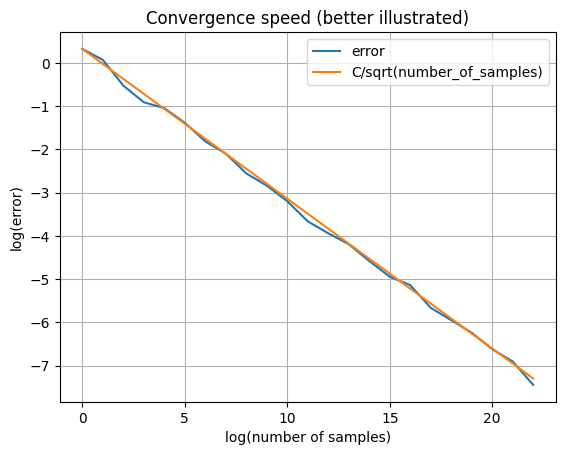

In [8]:
plt.plot(ms, np.log(error), label = 'error')
plt.title("Convergence speed (better illustrated)")
plt.plot(ms, np.log(1/np.sqrt(2**ms) * error[0]), label = 'C/sqrt(number_of_samples)')
plt.xlabel('log(number of samples)')
plt.ylabel('log(error)')
plt.grid(True)
plt.legend()
plt.show()

### Task 2
Suppose we have a random sample $X_1, \dots, X_n$ of independent and identically distributed (i.i.d.) random variables with cumulative distribution function (CDF) $F$. The corresponding order statistics are denoted as:

$$
X_{(1)} \leq X_{(2)} \leq \dots \leq X_{(n)}
$$

where $X_{(k)}$ represents the $k$th smallest value in the sample.

### Order Statistics and the Beta Distribution
A key result derived during the seminar states that the CDF values of the order statistics follow a Beta distribution:

$$
F(X_{(k)}) \sim \text{Beta}(k, n-k+1).
$$

Since $F(X)$ transforms the original random variable $X$ into a uniform $[0,1]$ random variable, we can generate order statistics using the inverse CDF method.

### Simulation Approach
To simulate the order statistics $X_{(k)}$, we follow these steps:


1. Generate Beta-Distributed Values: Sample $U_k \sim \text{Beta}(k, n-k+1)$ for each $k = 1, \dots, n$.
2. Transform Back Using $F^{-1}$: Compute the corresponding order statistic as:
$$
    X_{(k)} = F^{-1}(U_k),
$$
where $F^{-1}$ is the inverse CDF (or quantile function) of $F$.


Monte Carlo Simulation Example

1. If $X_i \sim U(0,1)$, then $F(x) = x$, so the order statistics are simply:
$$
  X_{(k)} = U_k, \quad U_k \sim \text{Beta}(k, n-k+1).
$$
2. If $X_i \sim Exp(\lambda)$, then we use the exp quantile function:
$$
  X_{(k)} = -\frac{\ln{U_{(k)}}}{\lambda},
$$

Main advantage comparing to a naïve approach is that we use $n$ times less samples.


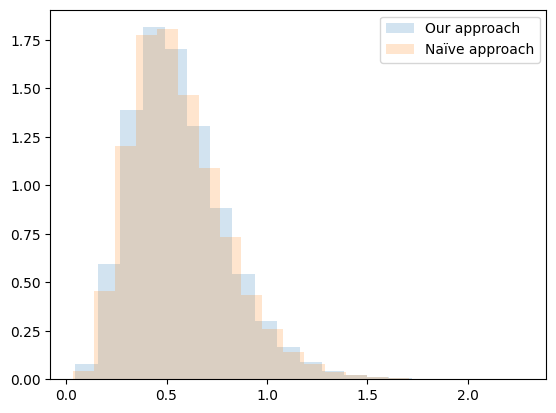

In [9]:
k, n = 6, 10
lam = 1.5
N = 100_000
def uni_to_exp(u, lam):
    return -np.log(1-u) / lam

# Our approach
U_k = np.random.beta(k,n + 1 - k,N)
Exp_k = uni_to_exp(U_k, lam)
plt.hist(Exp_k, bins=20, density=True, label = 'Our approach', alpha=0.2)

# Naïve approach
U = np.random.uniform(size = (N, n))
E = uni_to_exp(U, lam)
E = np.sort(E, axis=-1)#np.sort(E, axis=-1)
Exp_k_naive = E[:, k-1]
plt.hist(Exp_k_naive, bins=20, density=True, label = 'Naïve approach', alpha=0.2)
plt.legend()
plt.show()


In [10]:
stats.ks_2samp(Exp_k, Exp_k_naive)

KstestResult(statistic=np.float64(0.005500000000000005), pvalue=np.float64(0.09674858022485533), statistic_location=np.float64(0.45259042280533385), statistic_sign=np.int8(-1))

### Task 3
Assume that you can sample from the uniform distribution on (0,1). Explain how to use  the inverse transform method to generate a random variate with the standard right-triangular distribution, i.e., the distribution with pdf
$$
f(x)=2(1-x), \quad 0 \leq x \leq 1.
$$

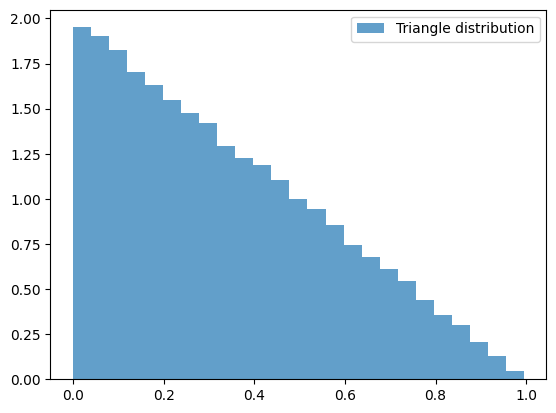

In [11]:
N = 100_000
U = np.random.uniform(size=N)
def uniform_to_triangle(u):
    return 1 - np.sqrt(u)
X = uniform_to_triangle(U)
plt.hist(X, bins=25, density=True, label = 'Triangle distribution', alpha=0.7)
plt.legend()
plt.show()

## Task 4

## Problem Statement
We aim to generate random samples from a Beta distribution using the Acceptance-Rejection method. The Beta distribution is given by:

$$
f_{\text{Beta}}(x; \alpha, \beta) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}, \quad 0 < x < 1
$$

where the Beta function is:

$$
B(\alpha, \beta) = \int_0^1 t^{\alpha - 1} (1 - t)^{\beta - 1} dt.
$$

### Preparation step 1: Choose a Proposal Distribution
A natural choice so far is:

$$
g(x) = 1, \quad 0 < x < 1
$$

which is the Uniform distribution $ U(0,1) $.

### Preparation step 2: Compute the Acceptance Constant
The Acceptance-Rejection method requires finding a constant $c$ such that:

$$
c g(x) \geq f_{\text{Beta}}(x; \alpha, \beta) \quad \text{for all } x \in (0,1).
$$

Since $g(x)=1$ and the maximum of the Beta density occurs at:

$$
x^* = \frac{\alpha - 1}{\alpha + \beta - 2}, \quad \text{for } \alpha, \beta > 1
$$

we can set:

$$
c = \frac{\left(\frac{\alpha-1}{\alpha+\beta-2}\right) ^ {(\beta-1)} \left(\frac{\alpha-1}{\alpha+\beta-2}\right) ^ {(\beta-1)} }{ \textit{Beta}(\alpha,\beta)}
$$

### The algo itself:
#### Step 1: Generate Candidate Samples
1. Sample $ X \sim U(0,1) $.
2. Sample $ U \sim U(0,1) $ independently.

#### Step 2: Accept or Reject
- Compute the acceptance probability:

  $$
  p = \frac{f_{\text{Beta}}(X; \alpha, \beta)}{cg(X)}
  $$

- If $ U \leq p $, accept $ X $ as a Beta sample.
- Otherwise, reject $ X $ and repeat from step 1.

Below we implement the logic described above. Note also that we calculate access_ratio - the number of accepted samples. Can you establish a connection of it with an abovementioned constant $c$?

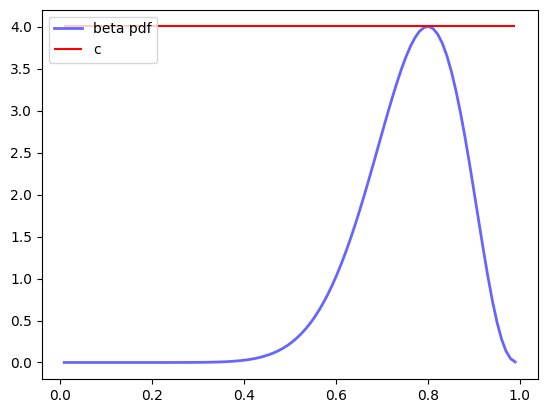

In [12]:
a, b = 13, 4 # >=1
def c_opt(a, b):
    return ((a-1)/(a+b-2)) ** (a-1) * ((b-1)/(a+b-2)) ** (b-1) / beta_function(a,b)
x = np.linspace(0.01, 0.99, 100)
plt.plot(x, beta.pdf(x, a, b), 'b-', lw=2, alpha=0.6, label='beta pdf')
plt.hlines(c_opt(a,b), 0.01,0.99, 'red', label='c')
plt.legend()
plt.show()

In [13]:
class Uniform_my:
    def __init__(self) -> None:
        pass

    def density(self, x):
        return 1

    def sample(self):
        return np.random.uniform()
beta_pdf = lambda x: beta.pdf(x, a, b)

def AR(f, g, g_sampler, c, N):
    samples = []
    samples_counter = 0
    for i in tqdm(range(N)):
        samples_counter += 1
        U = np.random.uniform()
        X = g_sampler.sample()
        # print(f'U={U}, c = {c}, g(X) = {g(X)}, f(X) = {f(X)}')
        while U * c * g(X) > f(X):
            samples_counter += 1
            U = np.random.uniform()
            X = g_sampler.sample()
        samples.append(X)
    return np.array(samples), N / samples_counter


In [14]:
N = 10000
uni = Uniform_my()
samples_beta, access_ratio = AR(beta_pdf, uni.density, uni, c_opt(a, b), N)

100%|██████████| 10000/10000 [00:06<00:00, 1531.30it/s]


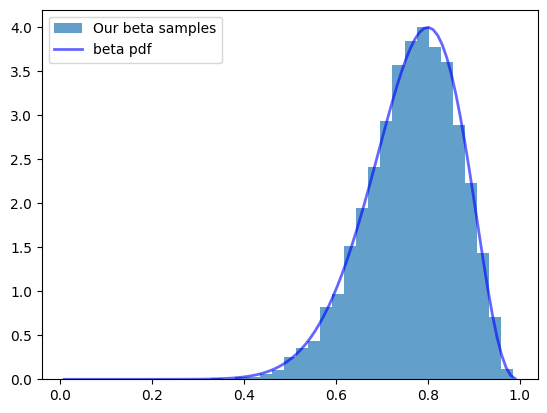

access_ratio = 0.25130047998391675


In [15]:
x = np.linspace(0.01, 0.99, 100)
plt.hist(samples_beta, bins=25, density=True, label = 'Our beta samples', alpha=0.7)
plt.plot(x, beta.pdf(x, a, b), 'b-', lw=2, alpha=0.6, label='beta pdf')
plt.legend()
plt.show()

# stats.ks_2samp(samples_beta, np.random.beta(a, b, N))
print(f'access_ratio = {access_ratio}')

## Task 5
FYI: $A^{-1} = \Gamma(\frac{1}{4}) / \sqrt{2}$

## Problem Statement
We want to sample from the probability density function:

$$
f(x) = A e^{-x^4/4}
$$

where $A$ is the normalization constant. We use the Acceptance-Rejection (AR) method with a Normal proposal distribution:

$$
g(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-x^2 / 2\sigma^2}.
$$

Our goal is to find the optimal value of $\sigma^*$ that maximizes the acceptance probability, i.e., minimizes the constant $c$ in the AR method.

## Acceptance-Rejection Method
The AR method requires choosing a minimal constant $c$ such that:

$$
c g(x) \geq f(x) \quad \text{for all } x.
$$

### Preparational step 1: Compute the Constant $c$
The optimal value of $c$ is given by:

$$
c = \sup_{x \in \mathbb{R}} \frac{f(x)}{g(x)}.
$$

Substituting the given functions:

$$
c = \sup_{x \in \mathbb{R}} \frac{A e^{-x^4/4}}{\frac{1}{\sqrt{2\pi}\sigma} e^{-x^2 / 2\sigma^2}}.
$$

Rearranging:

$$
c = A \sqrt{2\pi} \sigma \sup_{x \in \mathbb{R}} e^{-x^4/4 + x^2 / 2\sigma^2}.
$$

Define the function:

$$
h(x) = -\frac{x^4}{4} + \frac{x^2}{2\sigma^2}.
$$

To establish $c$, we maximize $h(x)$ by differentiating:

$$
h'(x) = -x^3 + \frac{x}{\sigma^2} = x \left( \frac{1}{\sigma^2} - x^2 \right).
$$

Setting $h'(x) = 0$, we get:

$$
x^2 = \frac{1}{\sigma^2} \quad \Rightarrow \quad x^* = \pm \frac{1}{\sigma}.
$$

Computing $h(x^*)$:

$$
h(x^*) = \frac{1}{4\sigma^4}.
$$

To minimize $c(\sigma)$, differentiate with respect to $\sigma$:

$$
\frac{d}{d\sigma} \left( \sigma e^{\frac{1}{4\sigma^4}} \right) = e^{\frac{1}{4\sigma^4}} \left(1 - \frac{1}{\sigma^2} \right).
$$

Setting this to 0:

$$
1 - \sigma^2 = 0 \quad \Rightarrow \quad \sigma^* = 1.
$$

Thus, the optimal choice of $\sigma$ is:

$$
\sigma^* = 1.
$$
### Algo

#### Step 1: Generate Candidate Samples
1. Sample $X \sim \mathcal{N}(0, \sigma^*)$.
2. Sample $U \sim U(0,1)$ independently.

#### Step 2: Accept or Reject
- Compute the acceptance probability:

  $$
  p = \frac{f(X)}{c g(X)}
  $$

- If $U \leq p$, accept $X$ as a sample from $f(x)$.
- Otherwise, reject $X$ and repeat.

Key issue: we need to be able to calculate normalizing constant A.

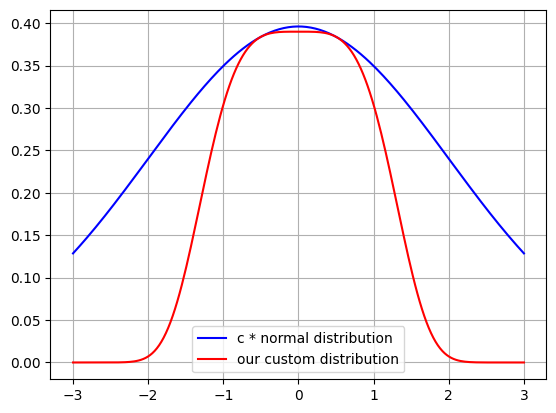

In [16]:
A_ = gamma_function(1/4) / np.sqrt(2)
sigma = 2
class Normal_my:
    def __init__(self, sigma) -> None:
        self.sigma = sigma
        pass

    def density(self, x):
        return norm.pdf(x, 0, self.sigma)

    def sample(self):
        return np.random.normal(loc=0,scale=self.sigma)

def custom_density(x):
    A_ = gamma_function(1/4) / np.sqrt(2)
    return np.exp(-x**4/4) / A_

def c_optimal_task_5(sigma):
    A = 1 / (gamma_function(1/4) / np.sqrt(2))
    return np.sqrt(2*np.pi) * sigma * A * np.exp(1 / (4 * sigma ** 4))

my_normal = Normal_my(sigma)
c = c_optimal_task_5(sigma)
x = np.linspace(-3, 3, 200)

plt.plot(x, c * my_normal.density(x), color = 'blue', label = 'c * normal distribution')
plt.plot(x, custom_density(x), color = 'red', label = 'our custom distribution')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
N = 100_000
samples_custom, access_ratio = AR(custom_density, my_normal.density, my_normal, c, N)

100%|██████████| 100000/100000 [00:32<00:00, 3065.60it/s]


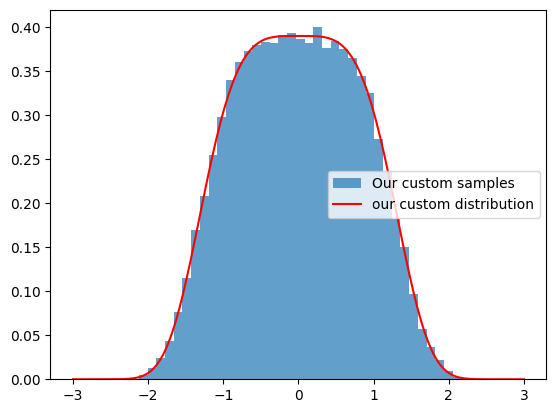

c = 1.9862764977006258, access_ratio = 0.5032611321362429


In [18]:
plt.hist(samples_custom, bins=40, density=True, label = 'Our custom samples', alpha=0.7)
plt.plot(x, custom_density(x), color = 'red', label = 'our custom distribution')
plt.legend()
plt.show()
print(f'c = {c}, access_ratio = {access_ratio}')

### Task 6

# Introduction to the Black-Scholes model

## The Black-Scholes Model
The Black-Scholes model, ommiting a lot of important assumptions, is the following one:

The stock price follows a geometric Brownian motion:
   $$
   dS_t = \mu S_t dt + \sigma S_t dW_t
   $$
   where $S_t$ is the stock price, $\mu$ is the drift, $\sigma$ is the volatility, and $W_t$ is a Wiener process.

Also there is some constant risk-free interest rate $r$.
## European Call Option
A call option is a financial contract that gives the holder the right, but not the obligation, to buy an underlying asset (e.g., a stock) at a predetermined price, known as the strike price $K$, on a specified expiration date $T$.  

The payoff of a European call option at expiration is:  

$$
\max(S_T - K, 0) =: (S_T - K)_{+}
$$  

where:  
- $S_T$ is the stock price at expiration.  
- $K$ is the strike price.  
- If $S_T > K$, the holder exercises the option and earns $S_T - K$.  
- If $S_T \leq K$, the option expires worthless.

## Discount to Present Value  
The expected payoff is estimated as the average over many simulations. The option price is the discounted expected payoff:  

$$
C = e^{-rT} \mathbb{E}[\max(S_T - K, 0)].
$$   

## The Black-Scholes Formula
The Black-Scholes formula for a European call option price $C$ is:

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2),
$$

where:
- $S_0$ is the current stock price.
- $K$ is the strike price.
- $T$ is the time to expiration.
- $r$ is the risk-free interest rate.
- $\sigma$ is the volatility of the stock.
- $\Phi(d)$ is the cumulative standard normal distribution function.
- $d_1$ and $d_2$ are given by:

  $$
  d_1 = \frac{\ln(S_0 / K) + (r + \sigma^2 / 2)T}{\sigma \sqrt{T}}, \quad
  d_2 = d_1 - \sigma \sqrt{T}.
  $$

For a European put option, the price $P$ is:

$$
P = K e^{-rT} \Phi(-d_2) - S_0 \Phi(-d_1).
$$

You'll study the derivation of it later.

## Interpretation
- $\Phi(d_1)$ represents the probability of the option being in the money under a risk-neutral measure.
- $\Phi(d_2)$ adjusts for discounting the expected payoff at expiration.

## Monte Carlo Pricing of Call Options under the Black-Scholes Model  


### Step 1: Simulating Stock Prices  
Under the Black-Scholes model, the stock price **under risk-neutral measure** follows a geometric Brownian motion:  

$$
dS_t = r S_t dt + \sigma S_t dW_t
$$  

where:  
- $S_t$ is the stock price at time $t$.  
- $r$ is the risk-free interest rate.  
- $\sigma$ is the volatility of the stock.  
- $W_t$ is a Wiener process (standard Brownian motion).  

Solving the SDE, we can establish the stock price at expiration $T$ is:  

$$
S_T = S_0 e^{(r - \frac{1}{2} \sigma^2) T + \sigma \sqrt{T} Z}
$$  

where $Z \sim N(0,1)$ is a standard normal random variable.  

### Step 2: Compute the Option Payoff  
For each simulated $S_T$, compute the call option payoff:  

$$
\max(S_T - K, 0).
$$  

Using Monte Carlo simulation, we approximate:  

$$
C \approx e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(S_T^{(i)} - K, 0),
$$  

where $S_T^{(i)}$ are simulated stock prices and $N$ is the number of simulations.  


In [19]:
Normal_pdf = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * Normal_pdf(d1) - K * np.exp(-r*T)* Normal_pdf(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*Normal_pdf(-d2) - S*Normal_pdf(-d1)

def CALL_sampling(S, K, T, r, sigma, N):
    Z = np.random.normal(size = N)
    S_T = S * np.exp((r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)
    Call = np.max([S_T - K, np.zeros(N)], axis=0)
    return Call.mean() * np.exp(- r * T), Call.std() * np.exp(-r * T) * t_distribution.ppf(0.99, N-1) / np.sqrt(N)

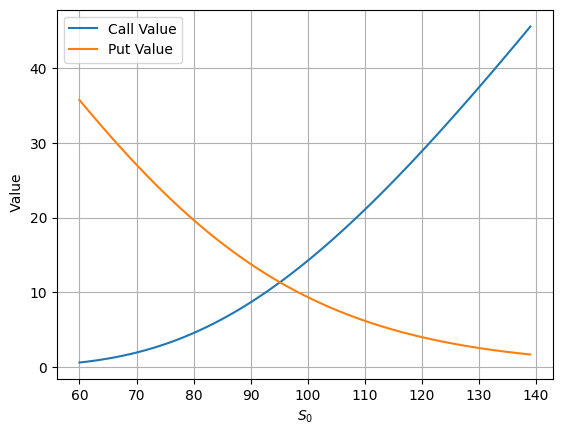

In [20]:
K = 100
r = 0.05
T = 1
sigma = 0.3

S = np.arange(60,140,1)

calls = [BS_CALL(s, K, T, r, sigma) for s in S]
puts = [BS_PUT(s, K, T, r, sigma) for s in S]
plt.plot(S, calls, label='Call Value')
plt.plot(S, puts, label='Put Value')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend()

In [21]:
CALL_sampling(100, K, T, r, sigma, N)

(np.float64(14.295877319950185), np.float64(0.16575131438453386))

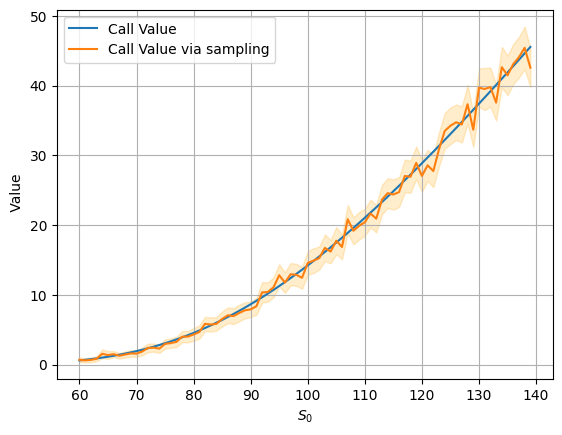

In [22]:
N = 1_000
calls = [BS_CALL(s, K, T, r, sigma) for s in S]
calls_sampling = np.array([CALL_sampling(s, K, T, r, sigma, N) for s in S])
plt.plot(S, calls, label='Call Value')
plt.plot(S, calls_sampling[:,0], label='Call Value via sampling')
plt.fill_between(S, calls_sampling[:,0] - calls_sampling[:,1], calls_sampling[:,0] + calls_sampling[:,1], alpha=0.2, color='orange')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend()

# Forward-Starting Call Option and Monte Carlo Pricing  

## Forward-Starting Call Option
A forward-starting call option is a type of exotic option where the strike price is determined at a future date instead of being fixed at inception. These options are often used in employee stock option plans or as part of structured financial products.  

### Key Features:  
- The option starts at time $0$, but its strike price $K$ is set at time $t_0$.  
- The strike price is typically a fraction of the underlying stock price at $t_0$, such as:  

  $$
  K = S_{t_0} \times m,
  $$  

  where $m$ is a predetermined proportion (e.g., $m = 1$ means an at-the-money option).  
- The option expires at $T > t_0$ and can only be exercised at expiration (European-style).  
- The payoff at expiration is:  

  $$
  \max(S_T - K, 0) = \max(S_T - m S_{t_0}, 0).
  $$  

## Monte Carlo Pricing of a Forward-Starting Call Option  
Since the strike price is determined at $t_0$, we cannot directly use the standard Black-Scholes formula (nevertheless one can easily derive an analytic expression under Black-Scholes model). Instead, we use Monte Carlo simulation to estimate its price.

### Step 1: Simulate Stock Prices  
Under the Black-Scholes model, the stock price follows the stochastic process:  

$$
dS_t = r S_t dt + \sigma S_t dW_t,
$$  

where:  
- $S_t$ is the stock price at time $t$.  
- $r$ is the risk-free interest rate.  
- $\sigma$ is the volatility of the stock.  
- $W_t$ is a Wiener process (standard Brownian motion).  

Using the closed-form solution for geometric Brownian motion, we simulate the stock prices at both $t_0$ and $T$:  

$$
S_{t_0} = S_0 e^{(r - \frac{1}{2} \sigma^2) t_0 + \sigma \sqrt{t_0} Z_1}
$$  

$$
S_T = S_{t_0} e^{(r - \frac{1}{2} \sigma^2) (T - t_0) + \sigma \sqrt{T - t_0} Z_2}
$$  

where $Z_1, Z_2 \sim N(0,1)$ are independent standard normal variables.

### Step 2: Compute the Option Payoff  
For each simulated path, compute the forward-starting call option payoff:  

$$
\max(S_T - m S_{t_0}, 0).
$$  

### Step 3: Discount to Present Value  
The price of the option is given by the expected discounted payoff:  

$$
C = e^{-rT} \mathbb{E}[\max(S_T - m S_{t_0}, 0)].
$$  

Using Monte Carlo, we approximate this as:  

$$
C \approx e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(S_T^{(i)} - m S_{t_0}^{(i)}, 0),
$$  

where $S_{t_0}^{(i)}$ and $S_T^{(i)}$ are simulated stock prices for different paths.

On the plot below one can see that resulted price is quite unstable. The main reason is the variance of our approximation. General method to resolve an issue is just to increase the number of samples. Are there any other solutions?


In [23]:
def Forward_starting_call_analytic(S, K, T1, T2, r, sigma, m):
    d1 = (np.log(1/m) + (r + sigma**2/2)*(T2-T1)) / (sigma*np.sqrt(T2-T1))
    d2 = d1 - sigma * np.sqrt(T2-T1)
    return S * ( Normal_pdf(d1) - np.exp(-r*(T2-T1)) * m * Normal_pdf(d2))

def Forward_starting_call_sampling(S, K, T1, T2, r, sigma, m, N):
    if T2 <= T1:
        print(f'T1 >= T2 with values T1 = {T1} and T2 = {T2}')
    Z1 = np.random.normal(size = N)
    Z2 = np.random.normal(size = N)
    S_T1 = S * np.exp((r - sigma ** 2 / 2) * T1 + sigma * np.sqrt(T1) * Z1)
    S_T2 = S_T1 * np.exp((r - sigma ** 2 / 2) * (T2-T1) + sigma * np.sqrt((T2-T1)) * Z2)
    Call = np.max([S_T2 - S_T1*m, np.zeros(N)], axis=0)
    return Call.mean() * np.exp(- r * T2), Call.std() * np.exp(-r * T2) * t_distribution.ppf(0.99, N-1) / np.sqrt(N)

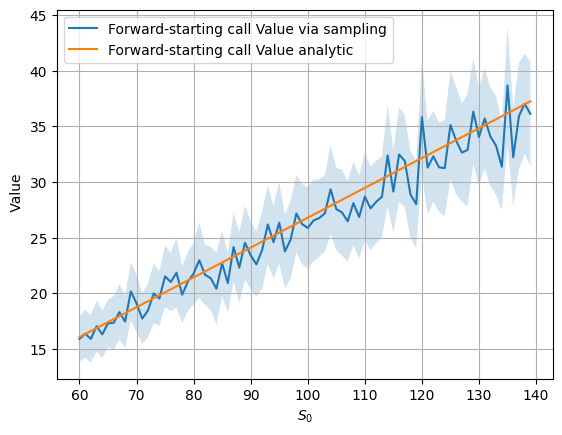

In [25]:
N = 1_000
T1 = 1
T2 = 4
m = 1

# calls = [BS_CALL(s, K, T, r, sigma) for s in S]
calls_sampling = np.array([Forward_starting_call_sampling(s, K, T1, T2, r, sigma, m, N) for s in S])
calls_analytic = np.array([Forward_starting_call_analytic(s, K, T1, T2, r, sigma, m) for s in S])
plt.plot(S, calls_sampling[:,0], label='Forward-starting call Value via sampling')
plt.plot(S, calls_analytic[:], label='Forward-starting call Value analytic')
plt.fill_between(S, calls_sampling[:,0] + calls_sampling[:,1], calls_sampling[:,0] - calls_sampling[:,1], alpha=0.2)
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend()